In [2]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Visualize the time series

Read in moviedata.csv file

In [3]:
data = pd.read_csv("moviedata.csv")
data.head()

,Month,Total Gross,% Of Year,Avg.,Top Movie of the Month,Gross,% Of Total
0,1/1/2000,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
1,2/1/2000,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2,3/1/2000,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
3,4/1/2000,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
4,5/1/2000,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


Clean column titles and change datatype

In [4]:
data.columns = ['Month', 'Total_Gross', 'Pct_Of_Year', 'Avg',
       'Top_Movie_of_the_Month ', 'Gross', 'Pct_Of_Total']
data.Month = pd.to_datetime(data.Month)
data.head()

,Month,Total_Gross,Pct_Of_Year,Avg,Top_Movie_of_the_Month,Gross,Pct_Of_Total
0,2000-01-01,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
1,2000-02-01,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2,2000-03-01,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
3,2000-04-01,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
4,2000-05-01,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


The above plot is against the index, let's plot against the datetime:

Let's make the index the datetime

In [5]:
data.index = data.Month
data.drop(["Month"], axis=1, inplace=True)
data.head()

,Total_Gross,Pct_Of_Year,Avg,Top_Movie_of_the_Month,Gross,Pct_Of_Total
Month,,,,,,
2000-01-01,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
2000-02-01,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2000-03-01,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
2000-04-01,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
2000-05-01,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


Plot Total Gross data

Fig. 1

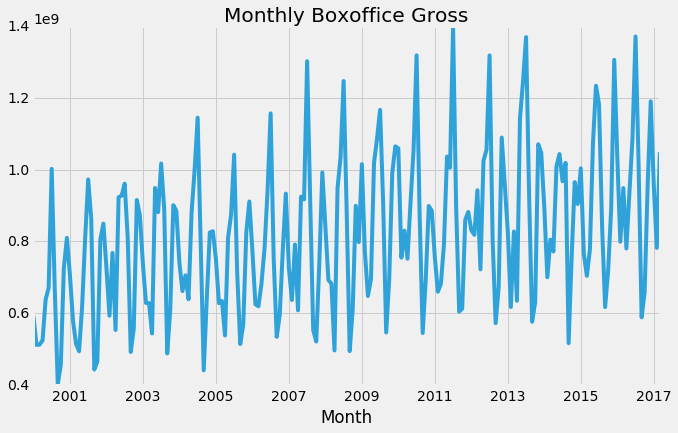

In [6]:
data.Total_Gross.plot(figsize=(10,6), title= 'Monthly Boxoffice Gross', fontsize=14)

# Step 2: Stationarize the series 

Check Stationarity
* constant mean
* constant variance
* autocovariance independent of time

Define a function for testing the mean and variance:

In [7]:
import matplotlib.pylab as plt

def test_stationarity(timeseries):
    #Determine rolling mean and standard dev
    rolling_mean = timeseries.rolling(window=12,center=False).mean()
    rolling_std = timeseries.rolling(window=12,center=False).std()
    
    #Plot statistics:
    window = plt.figure(figsize=(10, 6))
    series = plt.plot(timeseries, label='Series')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

Fig. 2 : Total Gross

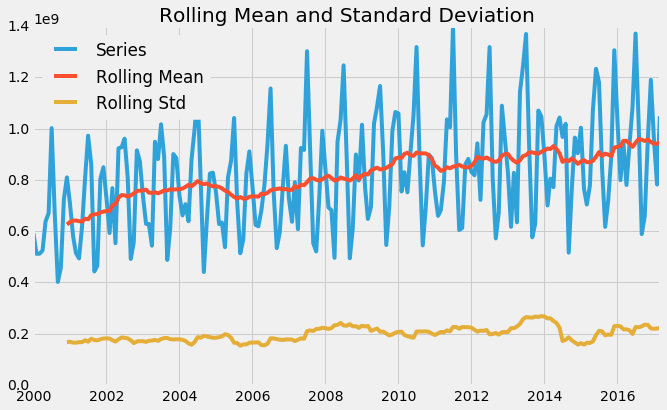

Results of Dickey-Fuller Test:
Test Statistic                  -1.704901
p-value                          0.428589
#Lags Used                      11.000000
Number of Observations Used    195.000000
Critical Value (5%)             -2.876479
Critical Value (1%)             -3.464337
Critical Value (10%)            -2.574733
dtype: float64


In [9]:
test_stationarity(data.Total_Gross)

Test different plots for stationarity:
* Log of gross sales
* First difference of gross sales
* First difference of log of gross sales
* Seasonal difference of gross sales
* Seasonal difference of log of gross sales

Fig. 3 : Log of Total Gross

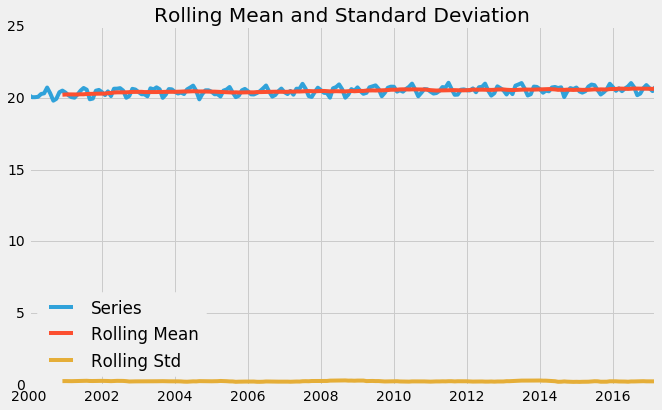

Results of Dickey-Fuller Test:
Test Statistic                  -2.170342
p-value                          0.217185
#Lags Used                      11.000000
Number of Observations Used    195.000000
Critical Value (5%)             -2.876479
Critical Value (1%)             -3.464337
Critical Value (10%)            -2.574733
dtype: float64


In [13]:
#log transform to penalizes higher values over small values
data.gross_log = data.Total_Gross.apply(lambda x: np.log(x))  
data.gross_log.dropna()
test_stationarity(data.gross_log)

Fig. 4 : For **first difference**, take the difference between an observation at t and at t-1

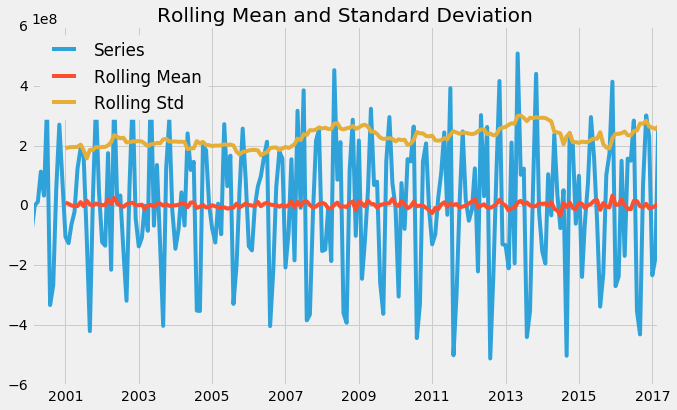

Results of Dickey-Fuller Test:
Test Statistic                -1.804181e+01
p-value                        2.656271e-30
#Lags Used                     1.000000e+01
Number of Observations Used    1.950000e+02
Critical Value (5%)           -2.876479e+00
Critical Value (1%)           -3.464337e+00
Critical Value (10%)          -2.574733e+00
dtype: float64


In [11]:
data.first_difference = data.Total_Gross - data.Total_Gross.shift(1)
data.first_difference = data.first_difference.dropna()
test_stationarity(data.first_difference)

FIg. 5 : For **log of first difference**, take the difference between log at t and log at t-1

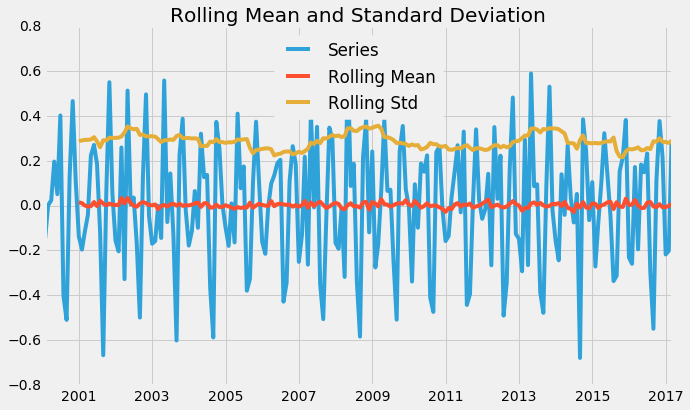

Results of Dickey-Fuller Test:
Test Statistic                -9.681726e+00
p-value                        1.199661e-16
#Lags Used                     1.100000e+01
Number of Observations Used    1.940000e+02
Critical Value (5%)           -2.876556e+00
Critical Value (1%)           -3.464515e+00
Critical Value (10%)          -2.574775e+00
dtype: float64


In [14]:
data.first_difference_log = data.gross_log - data.gross_log.shift(1)
data.first_difference_log = data.first_difference_log.dropna()
test_stationarity(data.first_difference_log)

Fig. 6 : For **seasonal shift**, take difference between t and t-12

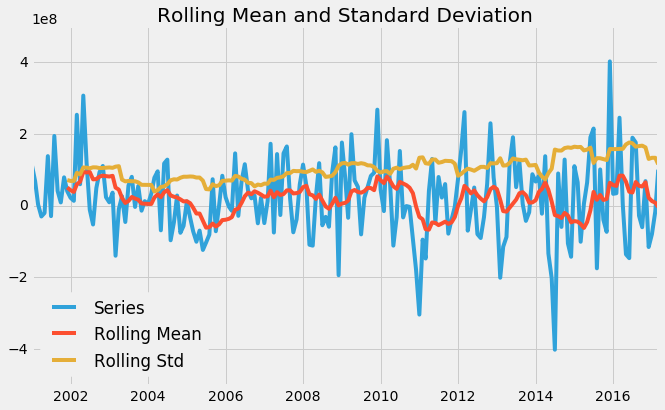

Results of Dickey-Fuller Test:
Test Statistic                  -5.453787
p-value                          0.000003
#Lags Used                      12.000000
Number of Observations Used    182.000000
Critical Value (5%)             -2.877555
Critical Value (1%)             -3.466800
Critical Value (10%)            -2.575308
dtype: float64


In [18]:
data.seasonal_shift = data.Total_Gross - data.Total_Gross.shift(12)
data.seasonal_shift = data.seasonal_shift.dropna()
test_stationarity(data.seasonal_shift)

Fig. 7 : For **log of seasonal shift**, take difference between log at t and log at t-12

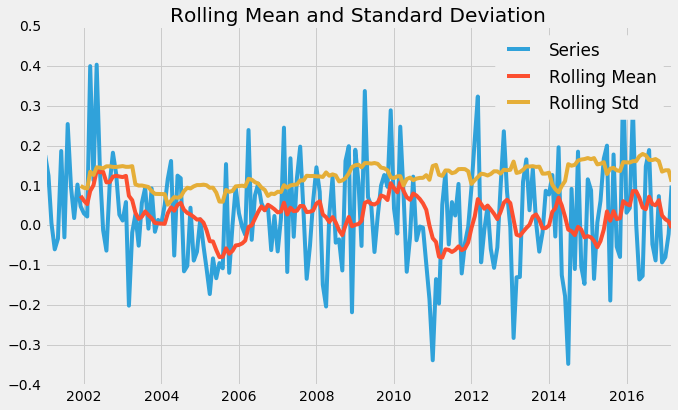

Results of Dickey-Fuller Test:
Test Statistic                  -5.411848
p-value                          0.000003
#Lags Used                      12.000000
Number of Observations Used    182.000000
Critical Value (5%)             -2.877555
Critical Value (1%)             -3.466800
Critical Value (10%)            -2.575308
dtype: float64


In [20]:
data.seasonal_shift_log = data.gross_log - data.gross_log.shift(12)
data.seasonal_shift_log = data.seasonal_shift_log.dropna()
test_stationarity(data.seasonal_shift_log)

FIg. 8 : For **seasonal first difference** take first difference of seasonal shift 

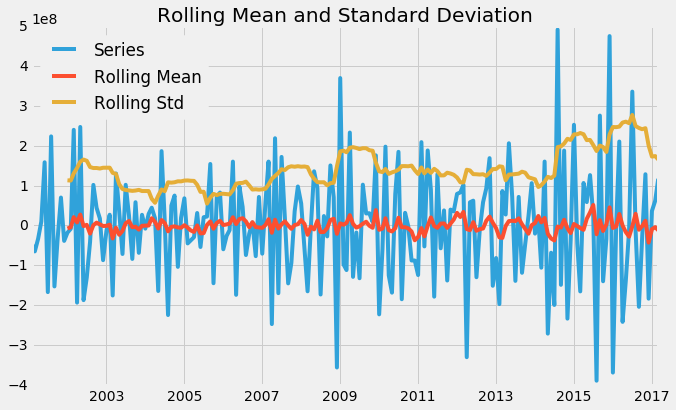

Results of Dickey-Fuller Test:
Test Statistic                -6.340930e+00
p-value                        2.755977e-08
#Lags Used                     1.500000e+01
Number of Observations Used    1.780000e+02
Critical Value (5%)           -2.877918e+00
Critical Value (1%)           -3.467632e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


In [22]:
data.seasonal_first_difference = data.seasonal_shift - data.seasonal_shift.shift(1)
data.seasonal_first_difference = data.seasonal_first_difference.dropna()
test_stationarity(data.seasonal_first_difference)

Fig. 9 : For **log  first difference** take first difference of log of seasonal shift 

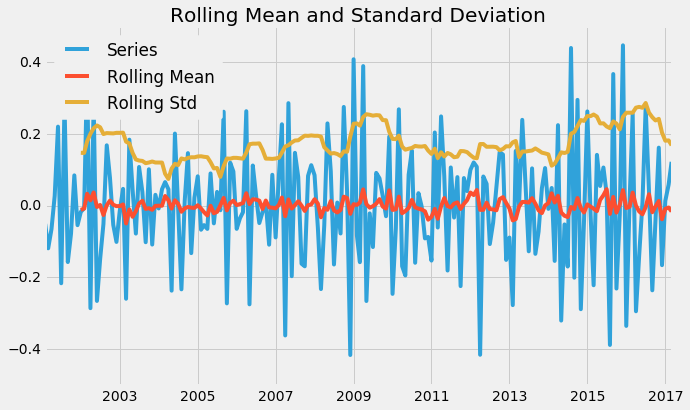

Results of Dickey-Fuller Test:
Test Statistic                -6.682906e+00
p-value                        4.297257e-09
#Lags Used                     1.500000e+01
Number of Observations Used    1.780000e+02
Critical Value (5%)           -2.877918e+00
Critical Value (1%)           -3.467632e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


In [26]:
data.seasonal_first_difference_log = data.seasonal_shift_log - data.seasonal_shift_log.shift(1)
data.seasonal_first_difference_log = data.seasonal_first_difference_log.dropna()
test_stationarity(data.seasonal_first_difference_log)

Based on the results of the augemented Dickey-Fuller Test, we that the first difference of the seasonal graph is stationary because the p-value is very small (the log is not that much smaller) ; we also see that the Test Statistic is less than 1% critical value, which means that the time series is stationary with 99% confidence

# Step 3: Plot ACF/PACF charts and find optimal parameters

ACF measures correlation of timeseries to a lagged version of itself i.e. t-12

PACF measures correlation of timeseries to a lagged version of itself i.e. t-12, after removing variations explained by timestampts in between

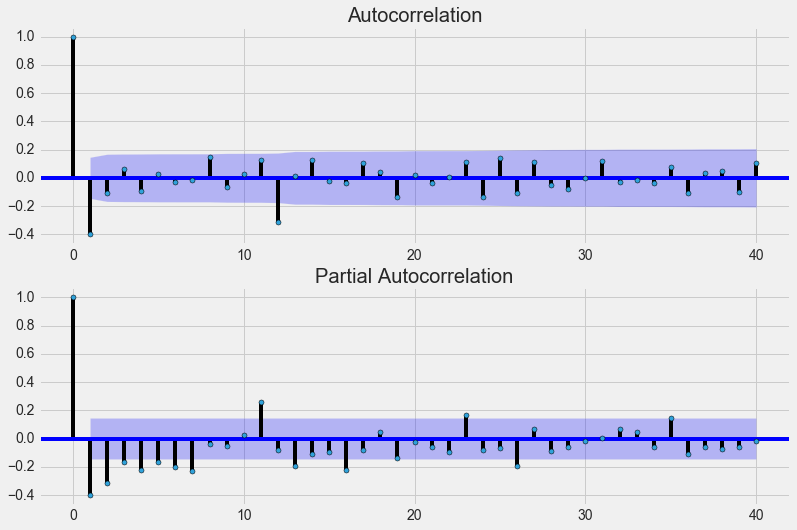

In [69]:
full_window = plt.figure(figsize=(12,8))
acf_window = full_window.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf(data.seasonal_first_difference.iloc[13:], lags=40, ax=acf_window)
pacf_window = full_window.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf(data.seasonal_first_difference.iloc[13:], lags=40, ax=pacf_window)

Instead of trying to read these plots, create a function to fit all possible combinations of parameters

In [32]:
# Define the p, d and q parameters 
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q 
params = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q 
seasonal_params = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Test Parameters for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(params[1], seasonal_params[1]))
print('SARIMAX: {} x {}'.format(params[1], seasonal_params[2]))
print('SARIMAX: {} x {}'.format(params[2], seasonal_params[3]))
print('SARIMAX: {} x {}'.format(params[2], seasonal_params[4]))

Test Parameters for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [33]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in params:
    for param_seasonal in seasonal_params:
        try:
            model = sm.tsa.statespace.SARIMAX(data.seasonal_shift,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:7234.58565211
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:6813.32685164
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:7282.17088866
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:7236.40699179
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:6907.2786235
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:6787.09283417
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:7696.27375844
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:7192.08299159
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:7400.33090285
SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:6809.84827782
SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:7281.32933401
SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:7193.05724745
SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:6926.3430946
SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:6802.46564298
SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC:7257.76420215
SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:6866.91855985
SARIMAX(0, 1, 0)x(1, 0, 0, 12) - AIC:7337.30630928
SARIMAX(0, 1, 0)x(1, 0, 1, 12) - AIC:7254.85600272
SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:6969.652594
SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AI

The combination : SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:6794.86

# Step 4: Build the SARIMA model

In [34]:
SARIMA_model = sm.tsa.statespace.SARIMAX(data.seasonal_first_difference,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = SARIMA_model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8096      0.185     -4.367      0.000      -1.173      -0.446
ar.S.L12      -0.4028      0.301     -1.336      0.182      -0.994       0.188
ma.S.L12      -0.9895      0.125     -7.929      0.000      -1.234      -0.745
sigma2      4.212e+16        nan        nan        nan         nan         nan


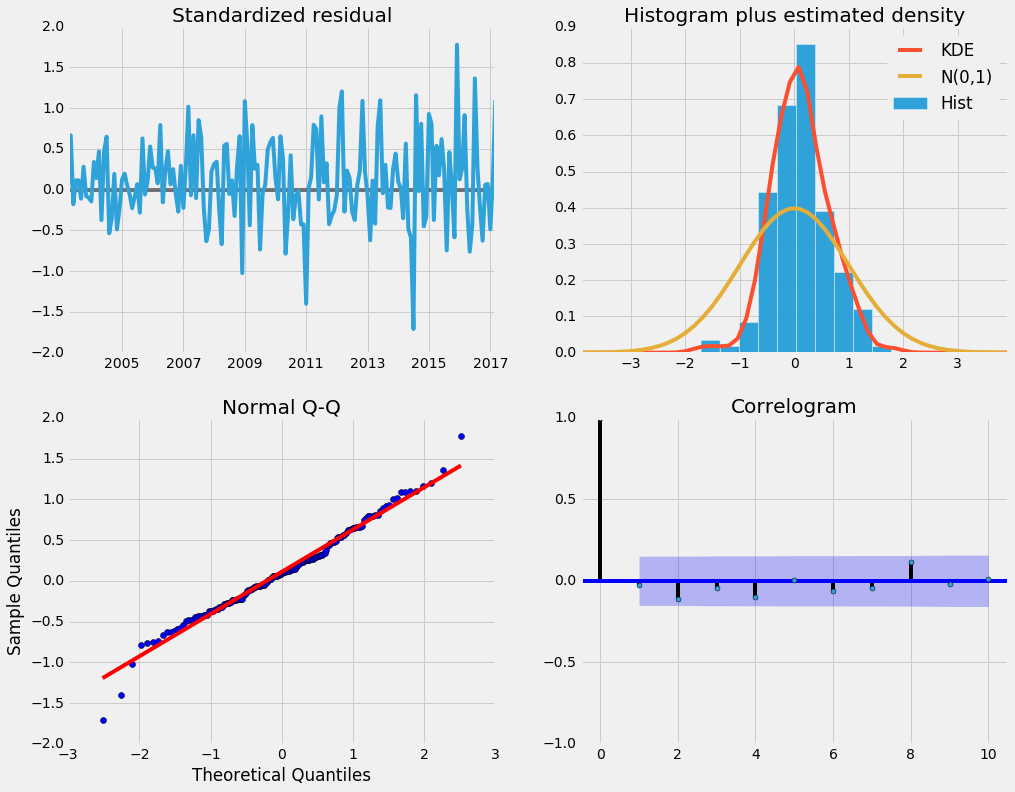

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot of Figure 7, the red KDE line follows closely with the N(0,1) lnormal distribution line with mean 0 and standard deviation of 1, so we know that the residuals are normally distributed. The qq-plot on the bottom left of Figure 8  also indicates that the residuals are normally distributed because it has a linear trend. The residuals over time, top left of Figure 8, does not display any obvious seasonality, indicating it is white noise. Finally, the autocorrelation (correlogram) plot on the bottom right of Figure 8, shows that the time series residuals have low correlation with their own lags.

Now create a prediction and compare it to the empirical data

In [95]:
prediction = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)

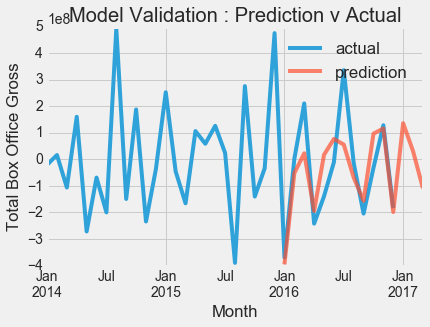

In [101]:
axis = data.seasonal_first_difference['2014':'2016'].plot(label='actual')
prediction.predicted_mean.plot(ax=axis, label='prediction', alpha=.7)

axis.set_title('Model Validation : Prediction v Actual')
axis.set_xlabel('Month')
axis.set_ylabel('Total Box Office Gross')
plt.legend()

plt.show()

In [92]:
# Get forecast 12 steps ahead in future
prediction = results.get_forecast(steps=36)


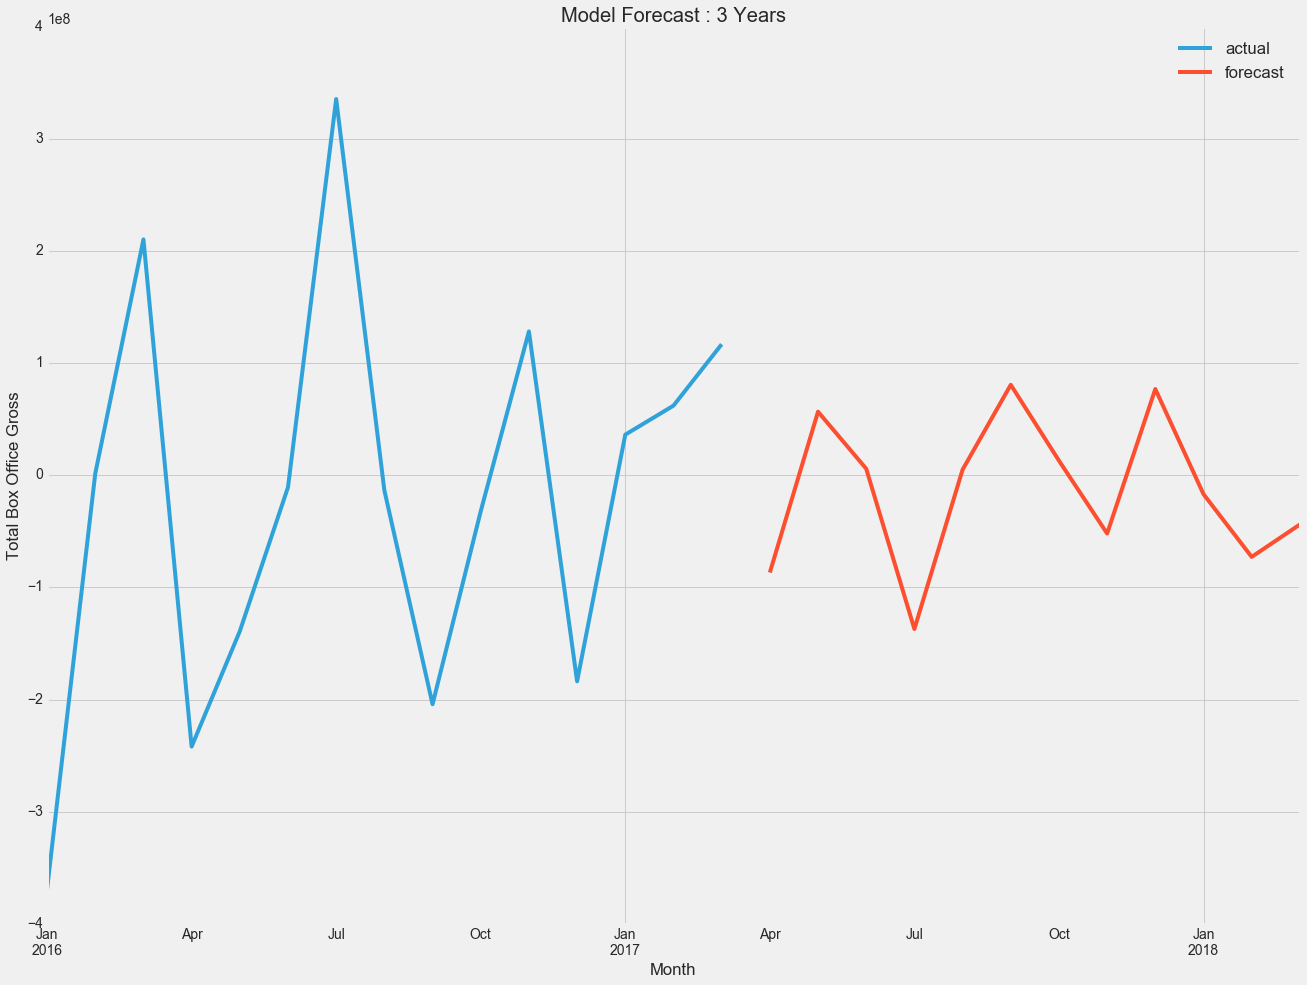

In [102]:
axis = data.seasonal_first_difference['2016':].plot(label='actual', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=axis, label='forecast')

axis.set_title('Model Forecast : 3 Years')
axis.set_xlabel('Month')
axis.set_ylabel('Total Box Office Gross')

plt.legend()
plt.show()